=== Processing Waypoint = ArgentineSea ===
=== Processing Waypoint = MargueriteBay ===


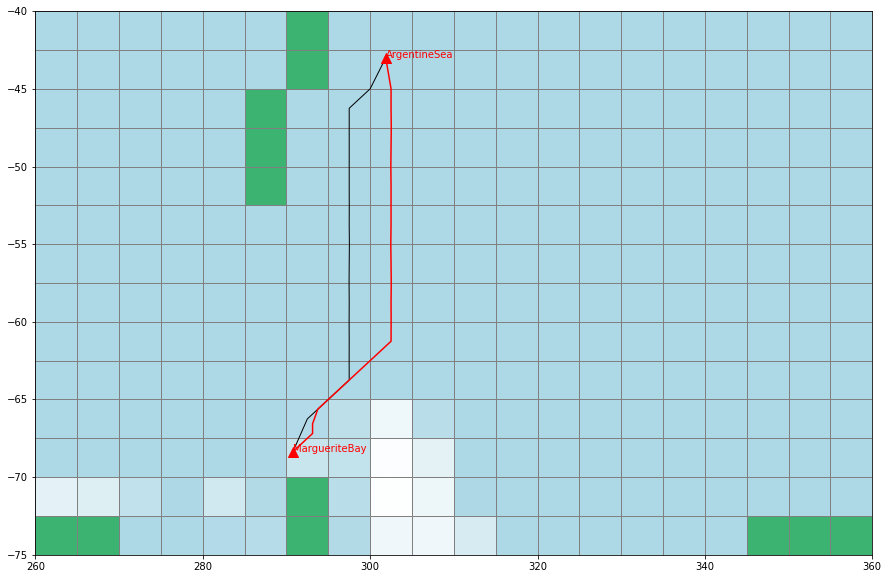

In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid

#read in Ice  & Currents Points
icePoints     = pd.read_json('../resources/icepoints2019-02-08.json')
icePoints     = pd.DataFrame.from_records(icePoints.icepoints)
currentPoints = pd.read_json('../resources/currentPoints.json')
currentPoints = pd.DataFrame.from_records(currentPoints.currentPoints)

longMin    = 260
longMax    = 360
latMin     = -75
latMax     = -40
cellWidth  = 5
cellHeight = 2.5

cellGrid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)

from RoutePlanner.Optimisation import TravelTime
OptInfo = {}
OptInfo['WayPoints']            = pd.read_csv('../resources/WayPoints_TestExample.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3 #Units km/hr

TT = TravelTime(cellGrid,OptInfo)
TT.Dijkstra(verbrose=True)

# Loading Ground Truth & Comparing
GT = pd.read_csv('../resources/TestExample_GroundTruth.csv')
GT['Long'] = GT['Long']+360
ax = TT.PlotPaths(waypoints=['ArgentineSea'])
ax.plot(GT['Long'],GT['Lat'],'r')

In [2]:
from RoutePlanner.Function import NewtonianDistance, NewtonianCurve

In [24]:
import numpy as np
Path = TT.Paths[1]


startPoint = Path['Path']['FullPath'][0,:][None,:]
endPoint   = Path['Path']['FullPath'][-1,:][None,:]

OrgcrossingPoints = np.concatenate([startPoint,
                                 Path['Path']['CrossingPoints'],
                                 endPoint])

Points = OrgcrossingPoints.copy()
iter=0
while iter < 800:
    for id in range(Points.shape[0]-2):
        Sp  = tuple(Points[id,:])
        Cp  = tuple(Points[id+1,:])
        Np  = tuple(Points[id+2,:])
        print(Sp,Cp,Np)
        nc = NewtonianCurve(TT.Mesh,Sp,Cp,Np,TT.OptInfo['VehicleInfo']['Speed'])
        TravelTime, CrossingPoint = nc.value()

        if id == 0:
            newPoints = CrossingPoint
        else:
            newPoints = np.concatenate([newPoints,CrossingPoint])
    Points = np.concatenate([startPoint,newPoints,endPoint])
    iter+=1



(290.75638888888886, -68.38916666666667) (291.47983847438127, -67.5) (295.0, -65.0)
(291.47983847438127, -67.5) (295.0, -65.0) (297.4919848306863, -62.5)
--Corner Case: Xs=[291.48,-67.50]; Xc=[295.00,-65.00]; Xe=[297.49,-62.50];
[[101.   297.5  -66.25]
 [102.   297.5  -63.75]
 [ 88.   292.5  -63.75]
 [102.   297.5  -63.75]]
(295.0, -65.0) (297.4919848306863, -62.5) (297.48828352239474, -60.0)
(297.4919848306863, -62.5) (297.48828352239474, -60.0) (297.4838044379377, -57.5)
(297.48828352239474, -60.0) (297.4838044379377, -57.5) (297.52319655372764, -55.0)
(297.4838044379377, -57.5) (297.52319655372764, -55.0) (297.5066566906308, -52.5)
(297.52319655372764, -55.0) (297.5066566906308, -52.5) (297.5000387750269, -50.0)
(297.5066566906308, -52.5) (297.5000387750269, -50.0) (297.49974963101783, -47.5)
(297.5000387750269, -50.0) (297.49974963101783, -47.5) (300.0, -45.0)
(297.49974963101783, -47.5) (300.0, -45.0) (301.8661111111111, -43.0)
--Corner Case: Xs=[297.50,-47.50]; Xc=[300.00,-45.00]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

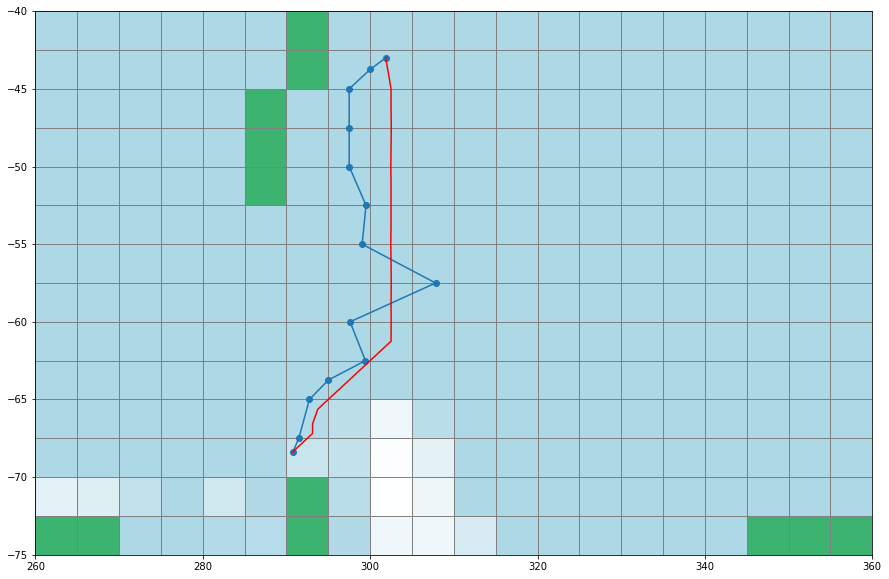

In [25]:
ax = cellGrid.plot(return_ax=True)

crossingPoints = np.concatenate([Path['Path']['FullPath'][0,:][None,:],
                                 Path['Path']['CrossingPoints'],
                                 Path['Path']['FullPath'][-1,:][None,:]])

ax.scatter(Points[:,0],Points[:,1])
ax.plot(Points[:,0],Points[:,1])
ax.plot(GT['Long'],GT['Lat'],'r')